In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import PIL.Image as Image
import numpy as np
import torch
import glob
from tqdm import tqdm
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import ipywidgets as widgets

In [2]:
# !pip install pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

PREFIX = '/kaggle/input/vesuvius-challenge-ink-detection'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# ax1.imshow(Image.open(PREFIX+'/train/1/mask.png'))
# ax2.imshow(Image.open(PREFIX+'/train/1/inklabels.png'))
# ax3.imshow(Image.open(PREFIX+'/train/1/ir.png'))
# plt.show()

In [4]:
# images = [Image.open(filename) for filename in tqdm(sorted(glob.glob(PREFIX+'/train/1/surface_volume/*.tif'))[0:5])]
# fig, axes = plt.subplots(1, len(images))
# for image, ax in zip(images, axes):
#     ax.imshow(image)
#     ax.set_xticks([])
#     ax.set_yticks([])
# plt.show()

In [5]:
# rect = (1550, 3500, 900, 950)
# fig, ax = plt.subplots()
# label = np.array(Image.open(PREFIX+'/train/1/inklabels.png'))
# ax.imshow(label)
# patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], facecolor='none', linewidth=2, edgecolor='r')
# ax.add_patch(patch)
# plt.show()

In [6]:
BUFFER = 30
LEARNING_RATE = 0.03
BATCH_SIZE = 32
Z_START = 27
Z_DIM = 10
TRAINING_STEPS = 30000

In [7]:
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in sorted(glob.glob(PREFIX+'/train/1/surface_volume/*.tif'))[Z_START:Z_START+Z_DIM]]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0)

label = torch.from_numpy(np.array(Image.open(PREFIX+'/train/1/inklabels.png'))).float()

In [8]:
rect = (1100, 3500, 700, 950)
mask = np.array(Image.open(PREFIX+'/train/1/mask.png'), dtype=np.float32)
not_border = np.zeros(mask.shape, dtype=np.bool_)
not_border[BUFFER:mask.shape[0]-BUFFER, BUFFER:mask.shape[1]-BUFFER] = True

arr_mask = np.array(mask) * not_border

inside_rect = np.zeros(mask.shape, dtype=np.bool_)
inside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = True

outside_rect = np.ones(mask.shape, dtype=np.bool_) * arr_mask
outside_rect[rect[1]:rect[1]+rect[3]+1, rect[0]:rect[0]+rect[2]+1] = False

pixels_inside_rect = np.argwhere(inside_rect)
pixels_outside_rect = np.argwhere(outside_rect)

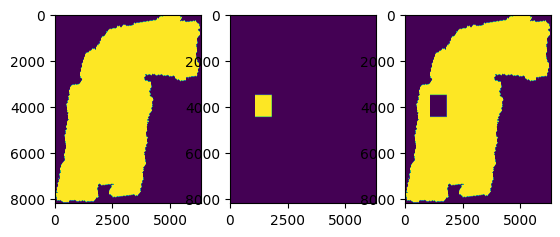

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(arr_mask)
ax2.imshow(inside_rect)
ax3.imshow(outside_rect)
plt.show()

In [10]:
class SubVolumeDataSet(data.Dataset):
    def __init__(self, image_stack, label, pixels):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-BUFFER:y+BUFFER+1, x-BUFFER:x+BUFFER+1].view(1, Z_DIM, 2*BUFFER+1, 2*BUFFER+1)
        inklabel = self.label[y, x].view(1)
        return subvolume, inklabel

In [11]:
class CNNModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
            nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
            nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2),
            nn.Flatten(start_dim=1),
            nn.LazyLinear(128), nn.ReLU(),
            nn.LazyLinear(1), nn.Sigmoid()
        )
        self.loss_fn = nn.BCELoss()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        subvolumes, inklabels = batch
        loss = self.loss_fn(self.forward(subvolumes), inklabels)
        self.log('train_loss', loss)
        return loss
    
    def predict_step(self, batch, batch_idx):
        subvolumes, _ = batch
        predictions = self.forward(subvolumes)
        return predictions
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=LEARNING_RATE)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'step'
            }
        }
    

In [12]:
# class DataModule(pl.LightningDataModule):
#     def __init__(self):
#         super().__init__()
#         self.batch_size = 32

#         self.train_data = SubVolumeDataSet(image_stack, label, pixels_outside_rect)
#         self.val_data = SubVolumeDataSet(image_stack, label, pixels_inside_rect)

#     def train_dataloader(self):
#         return data.DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=4)
#     def val_dataloader(self):
#         return data.DataLoader(self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=4)

In [13]:
# checkpoint_callback = pl.callbacks.ModelCheckpoint(
#     monitor="val_acc_epoch",
#     save_top_k=3,
#     mode="max"
# )

In [14]:
model = CNNModel()

train_data = SubVolumeDataSet(image_stack, label, pixels_outside_rect)
train_dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
predict_data = SubVolumeDataSet(image_stack, label, pixels_inside_rect)
predict_dataloader = data.DataLoader(predict_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

trainer = pl.Trainer(
    callbacks=[TQDMProgressBar(refresh_rate=10)],
    max_time="00:03:00:00",
    max_steps=TRAINING_STEPS
)
trainer.fit(model, train_dataloaders=train_dataloader)
predictions = trainer.predict(dataloaders=predict_dataloader)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:411: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [15]:
output = torch.zeros_like(label).float()
for i, data in enumerate(predictions):
    for j, value in enumerate(data):
        output[tuple(pixels_inside_rect[i*BATCH_SIZE+j])] = value

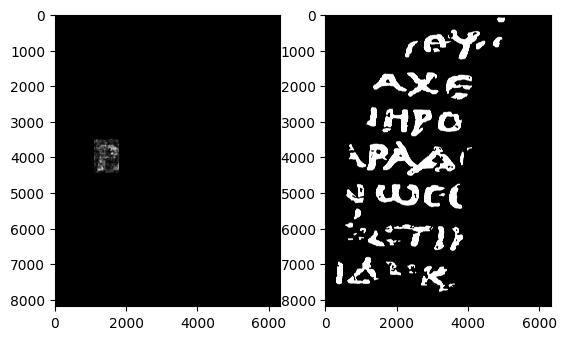

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

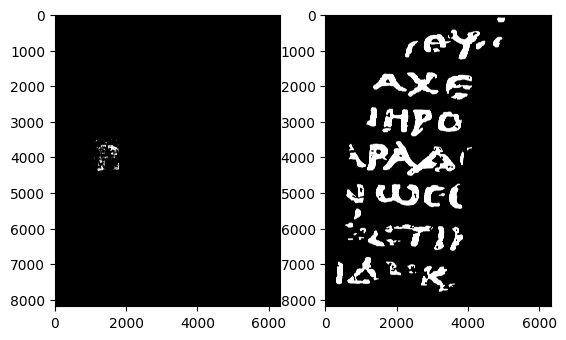

In [17]:
THRESHOLD = 0.4
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(output.gt(THRESHOLD).cpu(), cmap='gray')
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

In [18]:
def rle(output):
    pixels = np.where(output.flatten().cpu() > THRESHOLD, 1, 0).astype(np.uint8)
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return ' '.join(str(x) for x in runs)

rle_output = rle(output)
print("Id,Predicted\na," + rle_output + "\nb," + rle_output, file=open('submission.csv', 'w'))